<a href="https://colab.research.google.com/github/krronk/Facial_Emotion_Recognition/blob/main/MNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 26 14:30:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu102
0.10.0+cu102


In [ ]:
root_dir = '/content/drive/MyDrive/Single Emotions (1)/Train_set'
import os
os.listdir(root_dir)

['Train', 'train_labels.csv']

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import torch, torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([ transforms.ToPILImage(), 
                                transforms.Resize((224 ,224)),
                                transforms.CenterCrop(120),
                                transforms.RandomRotation(45),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.4681, 0.4030, 0.5275] , std =[1.5016, 1.5685, 1.5956])])

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image

class RAF_Dataset(Dataset):

  def __init__(self,csv_file,root_dir,transform=None):

    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,idx):
    img_path = os.path.join(self.root_dir,self.annotations.iloc[idx,1])
    image = read_image(img_path)
    label = torch.tensor(int(self.annotations.iloc[idx,2]))

    if self.transform:
      image = self.transform(image)

      return(image,label)

In [ ]:
train_set = RAF_Dataset ( csv_file = '/content/drive/MyDrive/Single Emotions (1)/Train_set/train_labels.csv' , 
                         root_dir = '/content/drive/MyDrive/Single Emotions (1)/Train_set/Train' ,
                         transform = transform)
len(train_set)

12271

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


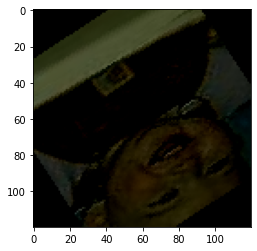

In [ ]:
import matplotlib.pyplot as plt
sample = train_set[1847][0].numpy().transpose(1,2,0)
plt.imshow(sample)
#print(train_set [0][1])

In [ ]:
train_loaders = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True ) 

In [ ]:
images,labels = next(iter(train_loaders))
labels

tensor([4, 2, 2, 5, 3, 3, 3, 6, 4, 3, 3, 6, 6, 4, 2, 0, 3, 3, 0, 0, 4, 6, 3, 3,
        0, 2, 3, 0, 4, 3, 6, 3, 3, 2, 5, 4, 6, 3, 4, 3, 2, 3, 4, 0, 3, 6, 3, 3,
        3, 3, 5, 6, 2, 3, 3, 3, 3, 3, 5, 2, 4, 4, 6, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


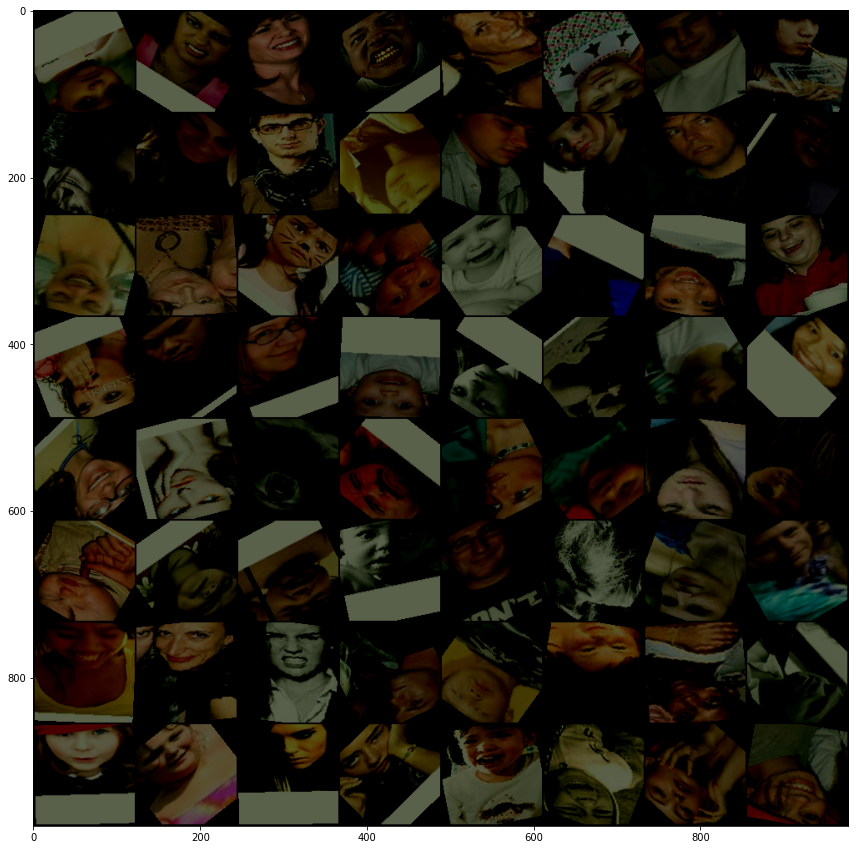

In [ ]:
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(images , nrows = 1)
sample = grid.numpy().transpose(1,2,0)
plt.figure(figsize=(15,15))
plt.imshow(sample)

In [ ]:
device = torch.device ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
model = torchvision.models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(in_features=1280, out_features=7, bias=True)
print(model)
optim = torch.optim.Adam(model.parameters() , lr = 1e-4)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth



MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [ ]:
crit = nn.CrossEntropyLoss( )
scalar = torch.cuda.amp.GradScaler()

In [ ]:
num_epochs = 50
total_step = len(train_loaders)

losses = []
train_accuracy = []


for epoch in range(num_epochs):
  for i, (images,labels) in enumerate(train_loaders):
        images = images.to(device)
        labels = labels.to(device)
        model = model.to(device)
        optim.zero_grad()
        with torch.cuda.amp.autocast():

          outputs = model(images)
          loss = crit(outputs, labels)
        
        
        loss.backward()
        optim.step()

        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax.squeeze()).float().mean()

        losses.append(loss.item()/ total_step)
        train_accuracy .append(accuracy.item())

        if (i+1) % 70 == 1:
            print ('Epoch [{}/{}], Step [{}/{}], Log_Loss: {:.4f} , Accuracy at the step {:.3f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item() , accuracy.item() ))

Epoch [1/50], Step [1/192], Log_Loss: 2.0239 , Accuracy at the step 0.094
Epoch [1/50], Step [71/192], Log_Loss: 1.4089 , Accuracy at the step 0.547
Epoch [1/50], Step [141/192], Log_Loss: 1.4742 , Accuracy at the step 0.469
Epoch [2/50], Step [1/192], Log_Loss: 1.1215 , Accuracy at the step 0.562
Epoch [2/50], Step [71/192], Log_Loss: 1.0414 , Accuracy at the step 0.656
Epoch [2/50], Step [141/192], Log_Loss: 1.1724 , Accuracy at the step 0.609
Epoch [3/50], Step [1/192], Log_Loss: 1.0131 , Accuracy at the step 0.625
Epoch [3/50], Step [71/192], Log_Loss: 1.0516 , Accuracy at the step 0.562
Epoch [3/50], Step [141/192], Log_Loss: 1.0906 , Accuracy at the step 0.578
Epoch [4/50], Step [1/192], Log_Loss: 0.8669 , Accuracy at the step 0.719
Epoch [4/50], Step [71/192], Log_Loss: 0.9589 , Accuracy at the step 0.641
Epoch [4/50], Step [141/192], Log_Loss: 0.9795 , Accuracy at the step 0.688
Epoch [5/50], Step [1/192], Log_Loss: 0.9117 , Accuracy at the step 0.641
Epoch [5/50], Step [71/192

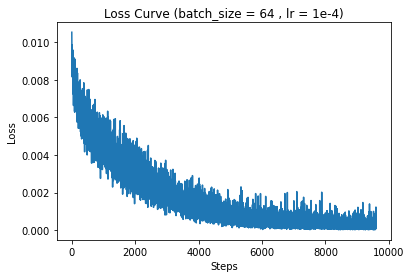

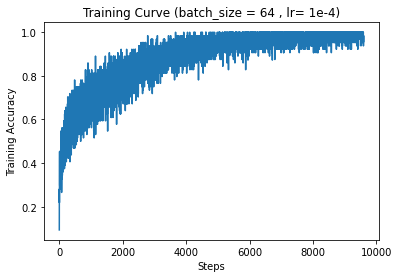

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Loss Curve (batch_size = 64 , lr = 1e-4)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()


plt.plot(train_accuracy)
plt.title("Training Curve (batch_size = 64 , lr= 1e-4)")
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")
plt.show()

In [ ]:
test_set = RAF_Dataset ( csv_file = '/content/drive/MyDrive/Single Emotions (1)/Test_set/test_labels.csv' , 
                         root_dir = '/content/drive/MyDrive/Single Emotions (1)/Test_set/Test' ,
                         transform = transform)

test_loaders = torch.utils.data.DataLoader(test_set, batch_size=32,shuffle=False )

In [ ]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images1, labels1 in test_loaders:
        images1 = images1.to(device)
        labels1 = labels1.to(device)
        model = model.to(device)
        outputs1 = model(images1)
        _, predicted = torch.max(outputs1.data, 1)
        total += labels1.size(0)
        correct += (predicted == labels1).sum().item()
    
    print('Accuracy of model is : {} %' .format(100*correct/total))

Accuracy of model is : 68.3181225554107 %


In [ ]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loaders):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([[227.,   5.,  11.,  17.,  20.,   8.,  41.],
        [ 10.,  35.,   3.,   7.,   7.,   6.,   6.],
        [  9.,   2.,  42.,  20.,  28.,  12.,  47.],
        [ 15.,   7.,  15., 967.,  59.,  26.,  96.],
        [  8.,   4.,  26.,  42., 294.,  20.,  84.],
        [ 13.,   2.,   7.,  13.,  19.,  88.,  20.],
        [ 32.,   2.,  26.,  66.,  69.,  17., 468.]])
tensor([0.6900, 0.4730, 0.2625, 0.8160, 0.6151, 0.5432, 0.6882])


Text(0.5, 69.0, 'Predicted label')

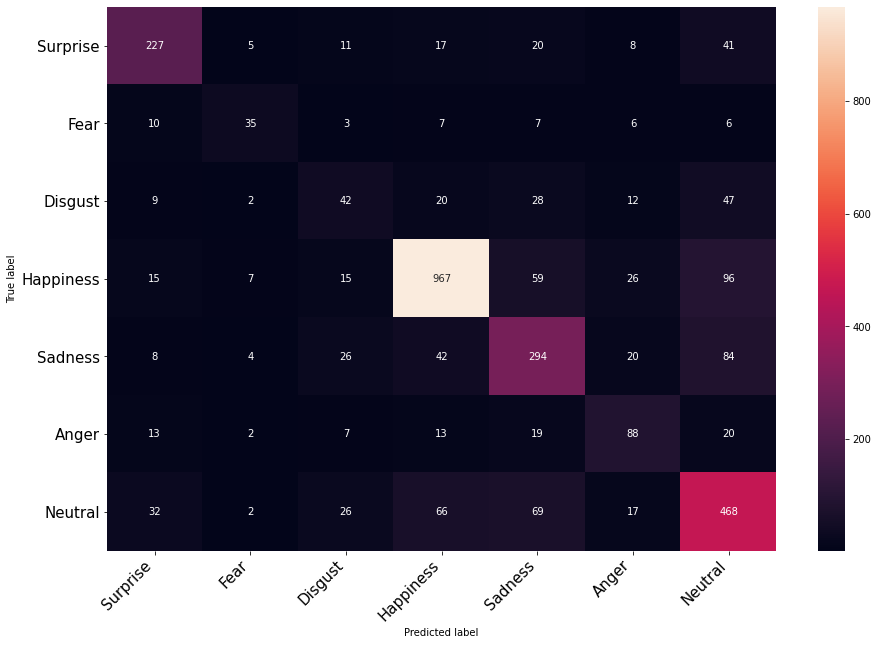

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(15,10))


class_names = [ 'Surprise' , 'Fear' , 'Disgust' , 'Happiness' , 'Sadness' ,'Anger' ,'Neutral' ]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
torch.save('model.state_dict()' , 'mnot_68.pth')

from google.colab import files
files.download('mnot_68.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model , 'mnot_1_68.pth')
from google.colab import files
files.download('mnot_1_68.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>